* changed by nov05 on 2024-12-09   
* local conda env `awsmle_py310`  
* Udacity AWS MLE Course 5  
    * [3.3 Multi-instance Training](https://www.evernote.com/shard/s139/u/0/sh/f94591b5-a428-4b26-80b6-7380f5d79ab2/NJ0iyyqycIRlmeWe-1qeBhGVlL1yky-1bSd1yCz9ZqC0JoLOC0m30OeByw)
    * [3.5 Excercise: Multi-instance training](https://www.evernote.com/shard/s139/u/0/sh/904108fe-8c48-4ddc-bcd9-fbd28630d110/rNquyVO6wK0fK1BhUfqv7FZEdfCsv0wqHrl94n8oIcn1AX-qlKS3itkZ6w)     


* [Docker containers for training and deploying models](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)  
  <img src="https://raw.githubusercontent.com/nov05/pictures/refs/heads/master/Udacity/20241119_aws-mle-nanodegree/20250126_your-algorithm-containers-flowchart-diagram.png" width=600>  
* In this notebook, we will use an `AWS SageMaker` pre-built linear algorithm `Docker` container in `AWS ECR`.   
  e.g. [Linear Learner (algorithm) in `us-east-1`](https://docs.aws.amazon.com/sagemaker/latest/dg-ecr-paths/ecr-us-east-1.html#linear-learner-us-east-1)     


### **Related content**   

* [Training with different level of AWS resources](https://gist.github.com/nov05/6f39c83c143d91175075fb8e7e871d0c)   
* 20241219 AWS Machine Learning - Training with `AWS EC2` (Amazon Elastic Compute Cloud)   
  https://www.youtube.com/watch?v=yBq0Fn7Z6RU    

In [19]:
!notepad C:\Users\guido\.aws\credentials

In [2]:
%pwd

'd:\\github\\udacity-aws-mle-nano-course5\\exercise_3.5'

In [20]:
# Define IAM role
## reset the session after updating credentials
import boto3 # type: ignore
boto3.DEFAULT_SESSION = None

import sagemaker # type: ignore
from sagemaker import get_execution_role # type: ignore
role_arn = get_execution_role()  ## get role ARN
if 'AmazonSageMaker-ExecutionRole' not in role_arn:
    print(f"Role ARN (voclabs): {role_arn}")  ## arn:aws:iam::026211625715:role/voclabs
    ## your own role here
    role_arn = "arn:aws:iam::026211625715:role/service-role/AmazonSageMaker-ExecutionRole-20241209T041445"
session = sagemaker.Session()
region = session.boto_region_name
bucket = session.default_bucket()
print("AWS Region: {}".format(region))
print("Default Bucket: {}".format(bucket))
print("Role Arn (SageMaker): {}".format(role_arn))

# S3 bucket prefix
prefix = 'gdelt/DEMO-data-distribution-types'

[12/09/24 10:05:10] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=846879;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=812866;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/09/24 10:05:11] WARNING  Couldn't call 'get_role' to get Role ARN from role name voclabs to get ]8;id=965836;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=316252;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#5902\5902]8;;\
                             Role path.                                                                            

Role ARN (voclabs): arn:aws:iam::026211625715:role/voclabs


                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=762588;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=701394;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

AWS Region: us-east-1
Default Bucket: sagemaker-us-east-1-026211625715
Role Arn (SageMaker): arn:aws:iam::026211625715:role/service-role/AmazonSageMaker-ExecutionRole-20241209T041445


In [21]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import io
import time
import copy
# import json
# import sys
import sagemaker.amazon.common as smac
import os

In [5]:
import platform
def get_gdelt(filename):
    s3 = boto3.resource('s3')
    if platform.system()=="Windows":  ## local
        data_path = '..\data\.gdelt.csv'  
    else:  ## SageMaker notebook instance
        data_path = '.gdelt.csv'
    s3.Bucket('gdelt-open-data').download_file('events/' + filename, data_path)
    df = pd.read_csv(data_path, sep='\t')  
    header = pd.read_csv('https://www.gdeltproject.org/data/lookups/CSV.header.historical.txt', sep='\t')
    df.columns = header.columns
    return df

In [6]:
data = get_gdelt('1979.csv')
print(data.shape)
data

[12/09/24 05:00:41] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=951741;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=90667;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

C:\Users\guido\AppData\Local\Temp\ipykernel_32772\2876313805.py:9: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')


(430940, 57)


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED
0,1,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
1,2,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
2,3,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,106.3590,-1903584,4.0,"Dizhou, Guangxi, China",CH,CH16,23.0036,106.3590,-1903584.0,20130203
3,4,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,-96.8067,1380944,3.0,"Dallas, Texas, United States",US,USTX,32.7831,-96.8067,1380944.0,20130203
4,5,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,34.6809,-779676,4.0,"Emunim, HaDarom, Israel",IS,IS01,31.7444,34.6809,-779676.0,20130203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430935,230397975,19791231,197912,1979,1979.9890,USA,UNITED STATES,USA,NaN,NaN,...,51.5148,10074674,4.0,"Tehran, Tehran, Iran",IR,IR26,35.7500,51.5148,10074674.0,20130206
430936,230397976,19791231,197912,1979,1979.9890,USA,UNITED STATES,USA,NaN,NaN,...,51.5148,10074674,4.0,"Tehran, Tehran, Iran",IR,IR26,35.7500,51.5148,10074674.0,20130206
430937,230397977,19791231,197912,1979,1979.9890,USA,WASHINGTON,USA,NaN,NaN,...,65.0000,-2089022,4.0,"Moscow, Moskva, Russia",RS,RS48,55.7522,37.6156,-2960561.0,20130206
430938,230397978,19791231,197912,1979,1979.9890,VNM,VIETNAM,VNM,NaN,NaN,...,0.0000,0,1.0,France,FR,FR,46.0000,2.0000,0.0,20130206


C:\Users\guido\AppData\Local\Temp\ipykernel_32772\143883384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EventCode'] = data['EventCode'].astype(object)


col_0,% observations
EventCode,
10,0.060275
11,0.001703
12,0.013786
13,0.014074
14,0.006790
...,...
1821,0.000223
1822,0.000601
1823,0.000079


,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Lat,Actor2Geo_Long
count,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000
mean,4.369694,5.127215,26.311911,26.111038,23.109048,23.637813
std,3.121310,2.637798,21.865323,61.125843,22.136466,57.693612
min,1.000000,0.000000,-85.622100,-179.050000,-85.622100,-179.050000
25%,2.000000,3.333333,10.000000,0.000000,0.000000,0.000000
50%,4.000000,5.000000,32.000000,28.229400,30.044500,19.500000
75%,6.000000,6.666667,40.400000,53.000000,39.928900,50.093800
max,54.000000,28.571429,85.000000,180.000000,85.000000,180.000000


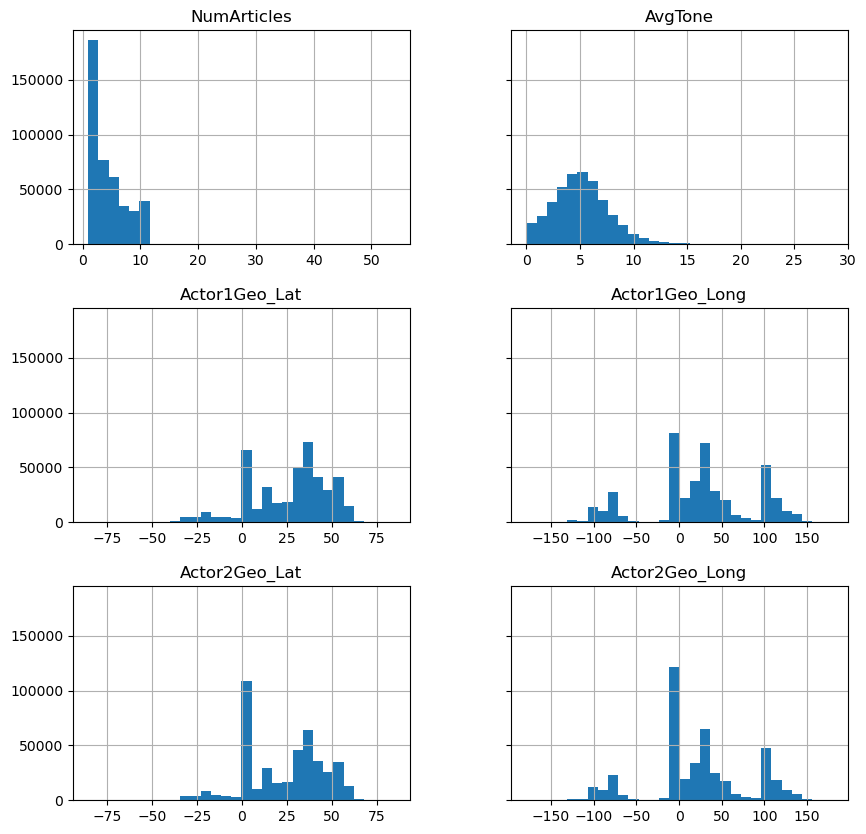

In [7]:
data = data[['EventCode', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']]
data['EventCode'] = data['EventCode'].astype(object)

for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

display(data.describe())
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))
plt.show()

In [8]:
events = pd.crosstab(index=data['EventCode'], columns='count').sort_values(by='count', ascending=False).index[:20]
events

Index([ 42,  43,  40,  10,  46,  51,  36,  20, 190,  57, 111, 120, 173,  30,
       112,  13,  12,  50, 110,  80],
      dtype='int64', name='EventCode')

## Similarly doing for other years

In [ ]:
def write_to_s3(bucket, prefix, channel, file_prefix, X, y):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype('float32'), y.astype('float32'))
    buf.seek(0)
    object_name = os.path.join(prefix, channel, file_prefix + '.data').replace('\\', '/')  ## windows to linux
    boto3.Session().resource('s3').Bucket(bucket).Object(object_name).upload_fileobj(buf)

def transform_gdelt(df, events=None):
    df = df[['AvgTone', 'EventCode', 'NumArticles', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']]
    df['EventCode'] = df['EventCode'].astype(object)
    if events is not None:
        df = df[np.in1d(df['EventCode'], events)]
    return pd.get_dummies(df[((df['Actor1Geo_Lat'] == 0) & (df['Actor1Geo_Long'] == 0) != True) &
                                   ((df['Actor2Geo_Lat'] == 0) & (df['Actor2Geo_Long'] == 0) != True)])
    
def prepare_gdelt(bucket, prefix, file_prefix, events=None, random_state=1729):
    df = get_gdelt(file_prefix + '.csv')
    model_data = transform_gdelt(df, events)
#    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).as_matrix(), 
#                                           [int(0.9 * len(model_data))])
    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).values, 
                                           [int(0.9 * len(model_data))])

    write_to_s3(bucket, prefix, 'train', file_prefix, train_data[:, 1:], train_data[:, 0])
    write_to_s3(bucket, prefix, 'validation', file_prefix, validation_data[:, 1:], validation_data[:, 0])

In [10]:
for year in range(1979, 1984):
    prepare_gdelt(bucket, prefix, str(year), events)

C:\Users\guido\AppData\Local\Temp\ipykernel_32772\2876313805.py:9: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\guido\AppData\Local\Temp\ipykernel_32772\1214988318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EventCode'] = df['EventCode'].astype(object)


[12/09/24 05:01:11] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=584550;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=833112;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/09/24 05:01:34] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=425968;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=231742;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

C:\Users\guido\AppData\Local\Temp\ipykernel_32772\1214988318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EventCode'] = df['EventCode'].astype(object)


[12/09/24 05:01:58] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=795793;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=870833;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/09/24 05:02:27] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=34776;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=700661;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

C:\Users\guido\AppData\Local\Temp\ipykernel_32772\1214988318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EventCode'] = df['EventCode'].astype(object)


[12/09/24 05:02:51] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=581718;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=294020;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/09/24 05:03:26] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=640458;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=275231;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

C:\Users\guido\AppData\Local\Temp\ipykernel_32772\1214988318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EventCode'] = df['EventCode'].astype(object)


[12/09/24 05:04:02] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=122395;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=861277;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/09/24 05:04:42] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=458586;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=389635;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

C:\Users\guido\AppData\Local\Temp\ipykernel_32772\1214988318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EventCode'] = df['EventCode'].astype(object)


[12/09/24 05:05:18] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=52572;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=176471;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/09/24 05:06:01] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=278681;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=240919;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

### 👉 **How to find AWS SageMaker pre-built container registry paths**  

*AWS > Documentation > Amazon SageMaker > ECR Paths*   
[**Docker Registry Paths and Example Code**](https://docs.aws.amazon.com/sagemaker/latest/dg-ecr-paths/ecr-us-east-1.html)   
Click on [US East (N. Virginia)](https://docs.aws.amazon.com/sagemaker/latest/dg-ecr-paths/ecr-us-east-1.html)   

[**Docker Registry Paths and Example Code for US East (N. Virginia) (us-east-1)**](https://docs.aws.amazon.com/sagemaker/latest/dg-ecr-paths/ecr-us-east-1.html)  
Click on [Linear Learner (algorithm)](https://docs.aws.amazon.com/sagemaker/latest/dg-ecr-paths/ecr-us-east-1.html#linear-learner-us-east-1)

In [3]:
## get container registry path for linear-learner via SageMaker SDK
import boto3
from sagemaker import image_uris
image_uris.retrieve(framework='linear-learner', region=boto3.Session().region_name)
## '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

[01/26/25 13:19:23] INFO     Same images used for training and inference. Defaulting to image     ]8;id=327515;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=803668;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#387\387]8;;\
                             scope: inference.                                                                     

                    INFO     Defaulting to the only supported framework/algorithm version: 1.     ]8;id=963597;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=419006;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#487\487]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=914697;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=652183;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#523\523]8;;\

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [22]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}  ## version: latest
container = containers[boto3.Session().region_name]

In [23]:
common_training_params = {
    "RoleArn": role_arn,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,  ## 👈 change the number here
        "InstanceType": "ml.c4.2xlarge",#,#"ml.t3.medium",#"ml.c5.xlarge",#"ml.m4.xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix)
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "25",
        "mini_batch_size": "500",
        "predictor_type": "regressor",
        "epochs": "2",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

In [25]:
%%time
common_training_params["ResourceConfig"]["InstanceCount"] = 4
print(f"👉 Instance count:", common_training_params["ResourceConfig"]["InstanceCount"])

replicated_job = 'DEMO-linear-replicated-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Job name is:", replicated_job)
replicated_training_params = copy.deepcopy(common_training_params)
replicated_training_params['TrainingJobName'] = replicated_job
replicated_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'FullyReplicated'

sharded_job = 'DEMO-linear-sharded-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Job name is:", sharded_job)
sharded_training_params = copy.deepcopy(common_training_params)
sharded_training_params['TrainingJobName'] = sharded_job
sharded_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'ShardedByS3Key'

for job, params in [[replicated_job, replicated_training_params], 
                    [sharded_job, sharded_training_params]]:
    start = time.perf_counter()
    start_cpu = time.process_time()
    sm = boto3.Session().client('sagemaker')
    sm.create_training_job(**params)
    status = sm.describe_training_job(TrainingJobName=job)['TrainingJobStatus']
    print(status)
    sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job)
    status = sm.describe_training_job(TrainingJobName=job)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    end = time.perf_counter()
    end_cpu = time.process_time()
    if status=='Failed':
        message = sm.describe_training_job(TrainingJobName=job)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')
    print(f"Elapsed CPU time: {end_cpu - start_cpu} seconds")
    print(f"Elapsed time (wall time): {end - start} seconds")
    print("--------------------------------------------------")
## find jobs in console "Amazon SageMaker AI > Training > Training jobs"

Job name is: DEMO-linear-sharded-2024-12-09-16-16-52
Job name is: DEMO-linear-replicated-2024-12-09-16-16-52
👉 Instance count: 4


[12/09/24 10:16:52] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=740812;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=40253;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

InProgress
Training job ended with status: Completed
Elapsed CPU time: 1.09375 seconds
Elapsed time (wall time): 363.1062584000174 seconds
--------------------------------------------------


[12/09/24 10:22:55] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=939836;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=930317;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

InProgress
Training job ended with status: Completed
Elapsed CPU time: 0.9375 seconds
Elapsed time (wall time): 362.7972677000216 seconds
--------------------------------------------------
CPU times: total: 2.03 s
Wall time: 12min 5s


* 1 instance

```text
[12/09/24 05:06:07] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1278
InProgress
Training job ended with status: Completed
Elapsed CPU time: 0.75 seconds
Elapsed time (wall time): 242.32852439995622 seconds
--------------------------------------------------
[12/09/24 05:10:10] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1278
InProgress
Training job ended with status: Completed
Elapsed CPU time: 0.859375 seconds
Elapsed time (wall time): 242.5319628000143 seconds
--------------------------------------------------
CPU times: total: 1.61 s
Wall time: 8min 4s
```

```text
Job name is: DEMO-linear-sharded-2024-12-09-11-29-05
Job name is: DEMO-linear-replicated-2024-12-09-11-29-05
👉 Instance count: 2
[12/09/24 05:29:05] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1278
InProgress
Training job ended with status: Completed
Elapsed CPU time: 0.984375 seconds
Elapsed time (wall time): 362.769124500046 seconds
--------------------------------------------------
[12/09/24 05:35:08] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1278
InProgress
Training job ended with status: Completed
Elapsed CPU time: 1.046875 seconds
Elapsed time (wall time): 363.0093902000226 seconds
--------------------------------------------------
CPU times: total: 2.03 s
Wall time: 12min 5s
```

```text
Job name is: DEMO-linear-sharded-2024-12-09-16-06-03
Job name is: DEMO-linear-replicated-2024-12-09-16-06-03
👉 Instance count: 3
[12/09/24 10:06:03] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1278
InProgress
Training job ended with status: Completed
Elapsed CPU time: 0.9375 seconds
Elapsed time (wall time): 363.08247819996905 seconds
--------------------------------------------------
[12/09/24 10:12:06] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1278
InProgress
Training job ended with status: Completed
Elapsed CPU time: 0.65625 seconds
Elapsed time (wall time): 242.79561470000772 seconds
--------------------------------------------------
CPU times: total: 1.59 s
Wall time: 10min 5s
```

```text
Job name is: DEMO-linear-sharded-2024-12-09-16-16-52
Job name is: DEMO-linear-replicated-2024-12-09-16-16-52
👉 Instance count: 4
[12/09/24 10:16:52] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1278
InProgress
Training job ended with status: Completed
Elapsed CPU time: 1.09375 seconds
Elapsed time (wall time): 363.1062584000174 seconds
--------------------------------------------------
[12/09/24 10:22:55] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1278
InProgress
Training job ended with status: Completed
Elapsed CPU time: 0.9375 seconds
Elapsed time (wall time): 362.7972677000216 seconds
--------------------------------------------------
CPU times: total: 2.03 s
Wall time: 12min 5s
```

* Each job had 4 log streams.   
  <img src="https://raw.githubusercontent.com/nov05/pictures/refs/heads/master/Udacity/20241119_aws-mle-nanodegree/imgonline-com-ua-twotoone-6s9A1CdWcVXF4m6-min.jpg" width=600>  

---   

## **Summary**  
  
* Job wall time (in seconds) comparison    

|   | 1 instance  | 2 instances  | 3 instances  | 4 instances  |
|-----------|-----------|-----------|-----------|-----------|
| **FullyReplicated** | 242.33 | 362.77 | 363.08 | 363.11 |
| **ShardedByS3Key** | 242.531 | 363.01 | 242.80 | 362.80 |